<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_Data_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook processes the ECG and PPG signals from MIMIC-III waveform database.
(https://archive.physionet.org/physiobank/database/mimic3wdb/matched/ ）


The Deep-ECG model is used to label the ECG, as well as PPG signals. The output of this notebook is PPG signals with 30s segements at 125 Hz, with Afib and NSR labels. The output data will be used to train a Deep-PPG model in Afib_PPG notebook.


The data cleaning and preprocessing is inspired by the following workflow, with some minor modification for our own application, where the order is:
1. Normalization
2. Segmentation
3. Flat line removal
4. Band-pass filter
5. Hampel filter

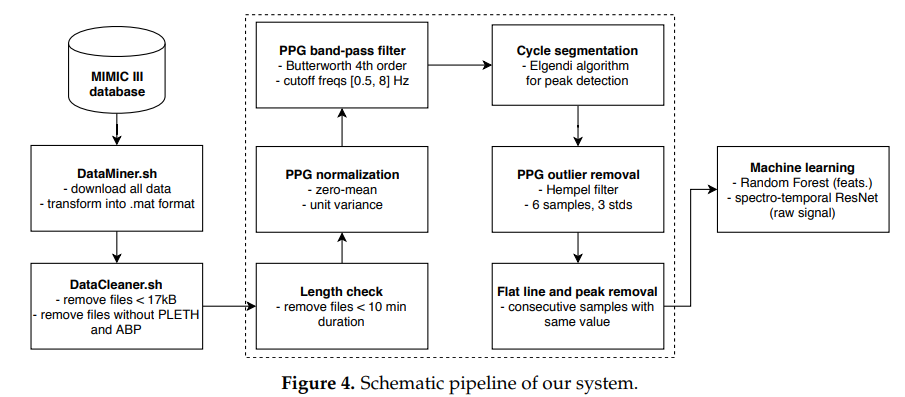

#2.Setup Environment

In [0]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import wfdb
import sklearn
from sklearn import preprocessing
import io
import pickle
import numba
from numba import jit
import tensorflow as tf

#3.Mine ECG and PPG data from WFDB

In [0]:
hd_names = []
for name in glob.glob("D:WFDB//matched/p09/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  42791 records that are bigger than 17kb


In [0]:
qualified_names = [] #a list of file names that contain both PPG and ECG Lead I waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'I' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #extact only records contrains ECG lead I and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ECG and PPG with more than 10min recording')

There are total 754 records that have both ECG and PPG with more than 10min recording


In [0]:
##use the same name for wfdb.rdrecord
##sampling freq is 125 Hz for both ECG and PPG: 
##Documentation: https://archive.physionet.org/physiobank/database/mimic3wdb/
ECG_signals = [] #create a  list to store all  ECG signals
PPG_signals = [] #create a  list to store all  PPG signals
names = []
for name in qualified_names:
  record = wfdb.rdrecord(name)

  ECG_index = record.sig_name.index('I')
  PPG_index = record.sig_name.index('PLETH')
  ECG_sig = record.p_signal.T[ECG_index]
  PPG_sig = record.p_signal.T[PPG_index]

  if np.isnan(ECG_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
    continue
  else:
    ECG_signals.append(ECG_sig)
    PPG_signals.append(PPG_sig)
    names.append(name)
print('ECG signals len:', len(ECG_signals))
print('PPG signals len:', len(PPG_signals))

ECG signals len: 417
PPG signals len: 417


In [0]:
#save ECG data
with open('D:WFDB//matched/ECG_signals_p09.pkl', "wb") as fp:
  pickle.dump(ECG_signals, fp)
#save PPG data
with open('D:WFDB//matched/PPG_signals_p09.pkl', "wb") as fp:
  pickle.dump(PPG_signals, fp)

#4.Process ECG and PPG raw data

##4.1 Load ECG and PPG data

In [0]:
with open('D:WFDB//matched/ECG_signals_p09.pkl', "rb") as fp:
  ECG_raw_signals = pickle.load(fp)

In [0]:
with open('D:WFDB//matched/PPG_signals_p09.pkl', "rb") as fp:
  PPG_raw_signals = pickle.load(fp)

##4.2 Normalization

###4.2.1 ECG data normalization

In [0]:
ECG_norm_signals = [sklearn.preprocessing.scale(i) for i in ECG_raw_signals]

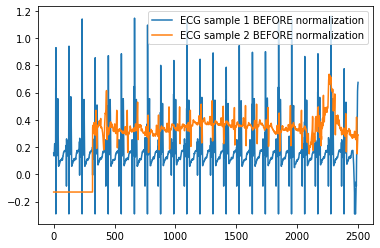

In [19]:
plt.plot(ECG_raw_signals[0][0:2500],label="ECG sample 1 BEFORE normalization")
plt.plot(ECG_raw_signals[2][0:2500],label="ECG sample 2 BEFORE normalization")
plt.legend()

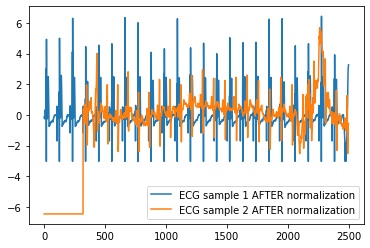

In [20]:
plt.plot(ECG_norm_signals[0][0:2500],label="ECG sample 1 AFTER normalization")
plt.plot(ECG_norm_signals[2][0:2500],label="ECG sample 2 AFTER normalization")
plt.legend()

###4.2.2 PPG data normalization

In [0]:
PPG_norm_signals = [sklearn.preprocessing.scale(i) for i in PPG_raw_signals]

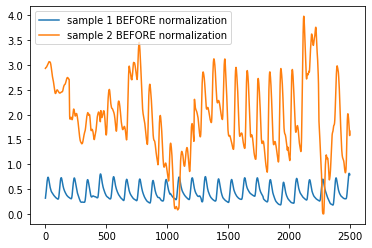

In [22]:
plt.plot(PPG_raw_signals[0][0:2500],label="sample 1 BEFORE normalization")
plt.plot(PPG_raw_signals[2][0:2500],label="sample 2 BEFORE normalization")
plt.legend()

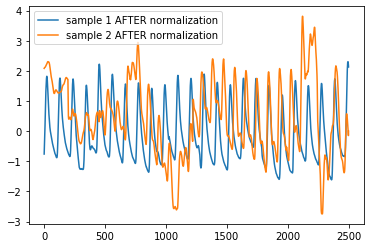

In [23]:
plt.plot(PPG_norm_signals[0][0:2500],label="sample 1 AFTER normalization")
plt.plot(PPG_norm_signals[2][0:2500],label="sample 2 AFTER normalization")
plt.legend()

## 4.3 Segmentation

In [0]:
def generate_segment_data(source,seg_len):
  n=0
  signals =[]
  for signal in source:
    for i in range(int(len(signal)/seg_len)):
      seg = signal[seg_len*i:seg_len*(i+1)]
      signals.append(seg)
    n+=1
#convert list into a numpy array and change its dim from (num of records, seg_len, 1) to (num of records, seg_len)
  signals = np.asarray(list(map(lambda x: np.reshape(x,3750),signals)))

  return signals

###4.3.1 ECG data segmentation

In [25]:
ECG_seg_signals = generate_segment_data(ECG_norm_signals, 3750)
print('ECG segmented signals dim:', ECG_seg_signals.shape)

ECG segmented signals dim: (83197, 3750)


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


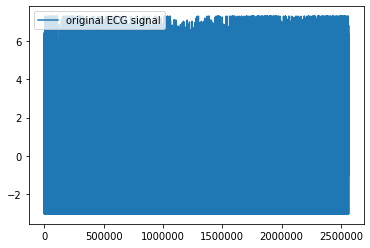

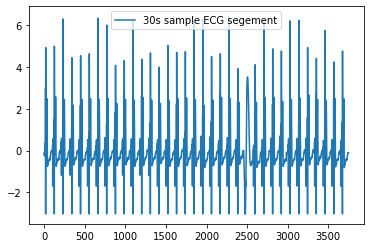

In [29]:
ECG_seg_sample = sklearn.preprocessing.scale(ECG_raw_signals[0])
plt.plot(ECG_seg_sample,label="original ECG signal")
plt.legend()
plt.figure() 
plt.plot(ECG_seg_signals[0],label='30s sample ECG segement')
plt.legend()

###4.3.2 PPG data segmentation

In [0]:
PPG_seg_signals = generate_segment_data(PPG_norm_signals, 3750)
print('PPG segmented signals dim:', PPG_seg_signals.shape)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


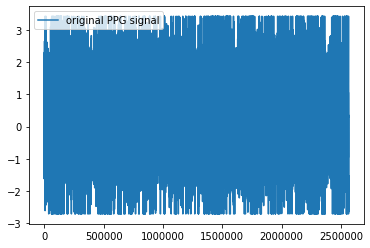

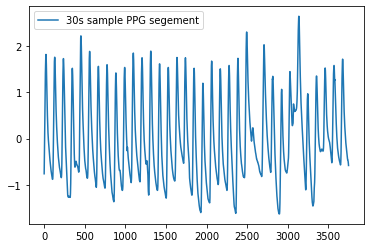

In [30]:
ppg_seg_sample = sklearn.preprocessing.scale(raw_PPG_signals[0])
plt.plot(ppg_seg_sample,label="original PPG signal")
plt.legend()
plt.figure() 
plt.plot(PPG_seg_signals[0],label='30s sample PPG segement')
plt.legend()

##4.4 Flat line removal

How to find the correct threshold? 
Threshold can't be too big, then nosiy data will be mistakenly labeled as flat line; threshold can neither be too small, then no flat line can be detected. 

> One method is to use histogram of the differentce of consecutive points, in a sense that small changes (such as flat line) tends to have similar values to each other, therefore, they will group together in histogram and show up as the max peak



In [0]:
def flat_line(signals,threshold = 0, percent = .45):
  clean_signals = []
  #create a list to store the index of the removed segments, this will be used
  #to remove the PPG signals with same index
  rm_list = []
  for i in range(len(signals)):
    #use np.diff to find consecutive points: diff = [i] - [i+1]
    signal_diff = np.diff(signals[i])
    #change value less than threshold to 0, and the rest to 1
    less = abs(signal_diff) <= threshold
    more = abs(signal_diff) > threshold
    signal_diff[less] = 0
    signal_diff[more] = 1
    #calculate what percent of 0 in the signal, remove the entire signal if 
    #percentage is higher than defined percent
    zero_per = sum(signal_diff==0)/len(signal_diff)
    if zero_per < percent:
      clean_signals.append(signals[i])
    else:
      rm_list.append(i)
    
    #track the progress for impatient programmer like me
    if i%10000 == 0:
      print("Processing on", i, "th sample")

  return clean_signals,rm_list

###4.4.1 ECG flat line removal

#### 4.4.1.2 Find ECG threshold

array([0.        , 0.        , 0.        , ..., 0.14268369, 0.06917997,
       0.06917997])

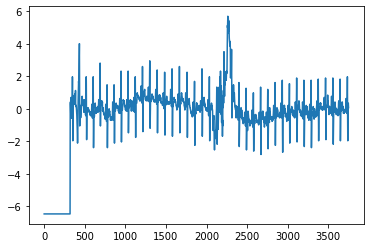

In [34]:
#take a look at one normalized example that has flat line regions
ECG_fl_sample1 = sklearn.preprocessing.scale(ECG_raw_signals[2])
plt.plot(ECG_fl_sample1[:3750])
ECG_signal_diff1 = abs(np.diff(ECG_fl_sample1[:3750]))
ECG_signal_diff1

threshold 0.0


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,1325,0,0,928,262,0,0,438,0,0,...,0,0,0,0,0,0,0,0,1,NaN
1,0,0.0178384,0.0356767,0.0535151,0.0713534,0.0891918,0.10703,0.124868,0.142707,0.160545,...,6.511,6.52884,6.54668,6.56451,6.58235,6.60019,6.61803,6.63587,6.65371,6.671543


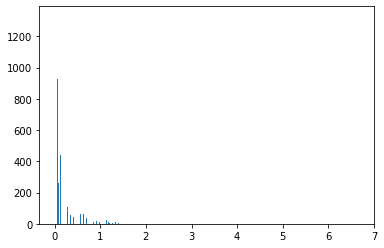

In [35]:
#plot the histogram and find the threshold
histogram = plt.hist(ECG_signal_diff1,bins=int(len(ECG_signal_diff1)/10)) 
histogram
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]
print("threshold", threshold)
pd.DataFrame(histogram)[0:2]

array([0.07068652, 0.        , 0.03029422, ..., 0.        , 0.        ,
       0.        ])

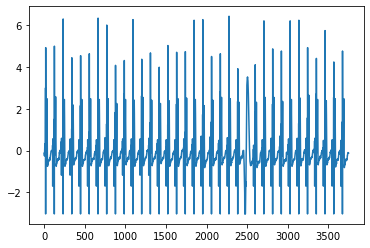

In [36]:
#take a look at another normalized example that has flat line regions
ECG_fl_sample2 = sklearn.preprocessing.scale(raw_ECG_signals[0])
plt.plot(ECG_fl_sample2[:3750])
ECG_signal_diff2 = abs(np.diff(ECG_fl_sample2[:3750]))
ECG_signal_diff2

threshold 0.0


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,1192,1171,294,139,3,70,82,66,20,52,...,2,2,2,1,0,1,0,0,1,NaN
1,0,0.0253262,0.0506524,0.0759786,0.101305,0.126631,0.151957,0.177283,0.202609,0.227936,...,9.24406,9.26938,9.29471,9.32004,9.34536,9.37069,9.39601,9.42134,9.44667,9.471993


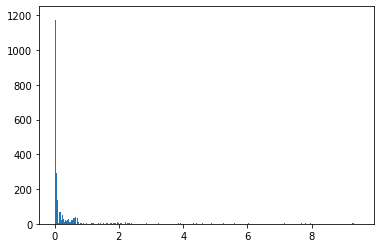

In [37]:
#plot the histogram and find the threshold
histogram = plt.hist(ECG_signal_diff2,bins=int(len(ECG_signal_diff2)/10))
histogram
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]
print("threshold", threshold)
pd.DataFrame(histogram)[0:2]

By comparing the above two examples, even threshold is set to the smallest value (which is 0), normal data that has no flat line region shows 1192 points of zero signal change, which is around 1/3 of total points. That means the percentage in flat_line function should be 33% + flat line% = 45% if we accept 12% flat line region in final data

####4.4.1.2 Find ECG flat line

In [0]:
ECG_clean_signals,ECG_rm_list = flat_line(ECG_seg_signals)

In [43]:
print('There are',len(ECG_clean_signals),'accepted ECG segments')
print('There are',len(ECG_rm_list),'rejected ECG segements that have flat line region more than ~12%')

There are 82181 accepted ECG segments
There are 1016 rejected ECG segements that have flat line region more than ~12%


In [0]:
#take the fist 50 samples to see the rejected segements
for i in range(len(ECG_rm_list[:100])):
  x = ECG_rm_list[i]
  plt.figure()
  plt.plot(ECG_seg_signals[x])

###4.4.2 PPG flat line removal

#### 4.4.2.1 Find PPG threshold 

array([0.01126795, 0.00804854, 0.00482912, ..., 0.0869242 , 0.08531449,
       0.08209508])

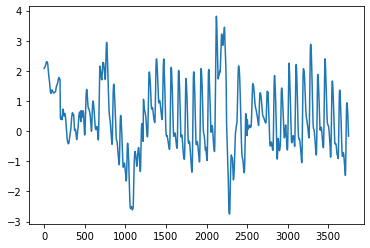

In [44]:
#take a look at one normalized example that has flat line regions
PPG_fl_sample1 = sklearn.preprocessing.scale(PPG_raw_signals[2])
plt.plot(PPG_fl_sample1[:3750])
PPG_signal_diff1 = abs(np.diff(PPG_fl_sample1[:3750]))
PPG_signal_diff1

threshold 0.0


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,141,102,101,124,91,121,115,115,111,94,...,0,0,0,0,0,0,0,0,1,NaN
1,0,0.00165705,0.0033141,0.00497116,0.00662821,0.00828526,0.00994231,0.0115994,0.0132564,0.0149135,...,0.604824,0.606481,0.608138,0.609795,0.611452,0.613109,0.614766,0.616423,0.61808,0.619737


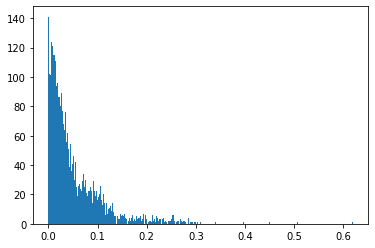

In [46]:
#plot the histogram and find the threshold
histogram = plt.hist(PPG_signal_diff1,bins=int(len(PPG_signal_diff1)/10)) 
histogram
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]
print("threshold", threshold)
pd.DataFrame(histogram)[0:2]

array([0.11975393, 0.10777853, 0.10179084, ..., 0.02395079, 0.01796309,
       0.02395079])

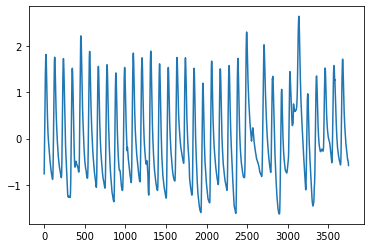

In [49]:
#take a look at another normalized example that has flat line regions
PPG_fl_sample2 = sklearn.preprocessing.scale(PPG_raw_signals[0])
plt.plot(PPG_fl_sample2[:3750])
PPG_signal_diff2 = abs(np.diff(PPG_fl_sample2[:3750]))
PPG_signal_diff2

threshold 0.011527116004362603


,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,166,0,0,0,0,0,0,0,0,407,...,0,0,0,0,0,0,0,0,2,NaN
1,0,0.000640395,0.00128079,0.00192119,0.00256158,0.00320198,0.00384237,0.00448277,0.00512316,0.00576356,...,0.233744,0.234385,0.235025,0.235665,0.236306,0.236946,0.237587,0.238227,0.238867,0.239508


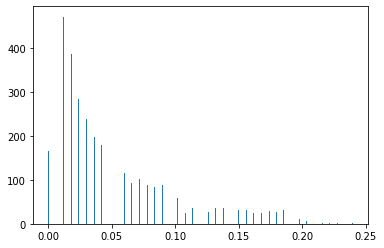

In [50]:
#plot the histogram and find the threshold
histogram = plt.hist(PPG_signal_diff2,bins=int(len(PPG_signal_diff2)/10))
histogram
max_index = np.argmax(histogram[0])
threshold = histogram[1][max_index]
print("threshold", threshold)
pd.DataFrame(histogram)[0:2]

By comparing the above two examples, even threshold is set to the smallest value (which is 0), normal data that has no flat line region shows 140 points of zero signal change, which is around 3% of total points. That means the percentage in flat_line function should be 3% + flat line% = 15% if we accept 12% flat line region in final data

####4.4.2.2 Find PPG flat line

In [0]:
PPG_clean_signals,PPG_rm_list = flat_line(PPG_seg_signals)

In [52]:
print('There are',len(PPG_clean_signals),'accepted PPG segments')
print('There are',len(PPG_rm_list),'rejected PPG segements that have flat line region more than ~10%')

There are 80767 accepted PPG segments
There are 2430 rejected PPG segements that have flat line region more than ~10%


In [0]:
#take the fist 50 samples to see the rejected segements
for i in range(len(PPG_rm_list[:100])):
  x = PPG_rm_list[i]
  plt.figure()
  plt.plot(PPG_seg_signals[x])

###4.4.3 Remove flat ECG and PPG 


In [57]:
#join the two lists rm_list from ECG, and PPG_rm_list
ECG_list = pd.DataFrame(ECG_rm_list)
PPG_list = pd.DataFrame(PPG_rm_list)
total_list = ECG_list.merge(PPG_list,how="outer")
print('There are in total',len(total_list),"flat line segments in the joint list")

There are in total 3401 flat line segments in the joint list


In [58]:
removal_list=total_list.values.tolist()
ECG_cl_signals = np.delete(ECG_seg_signals,total_list,0)
PPG_cl_signals = np.delete(PPG_seg_signals,total_list,0)
print('There are in total',len(ECG_cl_signals),"accpeted ECG segments")
print('There are in total',len(PPG_cl_signals),"accpeted PPG segments")

There are in total 79796 accpeted ECG segments
There are in total 79796 accpeted PPG segments


#5.Apply filters

##5.1 Band pass filter



In [0]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

###5.1.1 ECG band pass

In [0]:
ECG_bf_signals = []
for i in range(len(ECG_cl_signals)):
  ECG_bf_signal =butter_bandpass_filter(ECG_cl_signals[i],0.2,8,125,order=3)
  ECG_bf_signals.append(ECG_bf_signal)
  if i%10000 == 0:
      print("Processing on", i, "th sample")
print("After band pass filtering, there are:", len(ECG_bf_signals), "ECG segments")

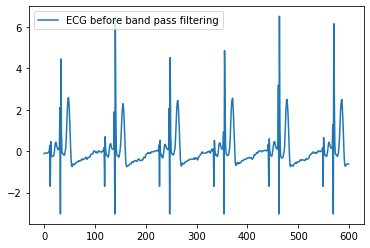

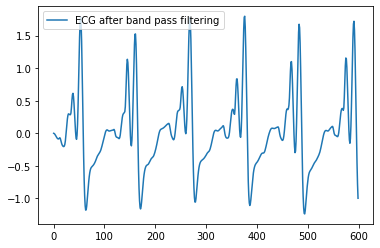

In [68]:
plt.plot(ECG_cl_signals[1][:600],label="ECG before band pass filtering")
plt.legend()
plt.figure()
plt.plot(ECG_bf_signals[1][:600], label="ECG after band pass filtering")
plt.legend()

###5.1.2 PPG band pass

In [0]:
PPG_bf_signals = []
for i in range(len(PPG_cl_signals)):
  PPG_bf_signal =butter_bandpass_filter(PPG_cl_signals[i],0.2,8,300,order=3)
  PPG_bf_signals.append(PPG_bf_signal)
  if i%10000 == 0:
      print("Processing on", i, "th sample")
print("After band pass filtering, there are:", len(PPG_bf_signals), "records")

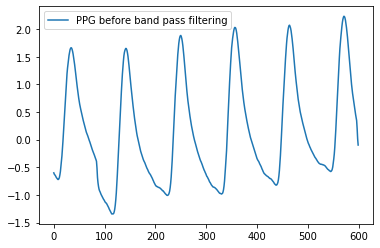

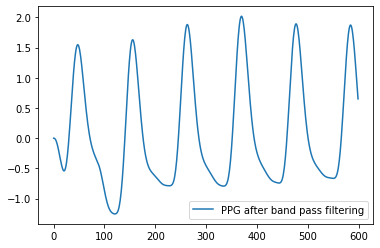

In [70]:
plt.plot(PPG_cl_signals[1][:600],label="PPG before band pass filtering")
plt.legend()
plt.figure()
plt.plot(PPG_bf_signals[1][:600], label="PPG after band pass filtering")
plt.legend()

##5.2 Hampel filter

The efffectiveness of hampel filter depends on how we play the two parameters: window_size and number of sigmas. 

In [0]:
#use numba to improve the speed of for loop
@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

###5.2.1 ECG hampel filter

In [83]:
ECG_hf_signals=[]
ECG_index=[]
for i in range(len(ECG_bf_signals)):
  if i%10000 == 0:
    print("hampel filering at", i+1, "th sample...")
  ECG_hf_signal, indices = hampel_filter_forloop_numba(ECG_bf_signals[i], 6)
  ECG_hf_signals.append(ECG_hf_signal)
  if indices != []:
    ECG_index.append([i,indices])
print("After Hample filtering, there are:", len(ECG_hf_signals), "ECG segments")
print("There are total", len(ECG_index),"ECG segements identified with outliers")

hampel filering at 1 th sample...
hampel filering at 10001 th sample...
hampel filering at 20001 th sample...
hampel filering at 30001 th sample...
hampel filering at 40001 th sample...
hampel filering at 50001 th sample...
hampel filering at 60001 th sample...
hampel filering at 70001 th sample...
After Hample filtering, there are: 79796 ECG segments
There are total 67484 ECG segements identified with outliers


In [0]:
ECG_index

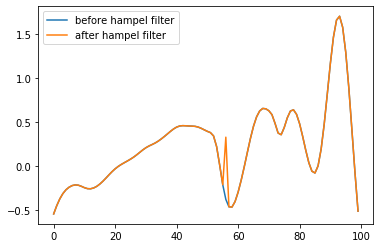

In [85]:
plt.plot(ECG_bf_signals[13][2600:2700], label = "before hampel filter")
plt.legend()
plt.plot(ECG_hf_signals[13][2600:2700], label = "after hampel filter")
plt.legend()

###5.2.2 PPG hampel filter

In [0]:
PPG_hf_signals=[]
PPG_index=[]
for i in range(len(PPG_bf_signals)):
  if i%10000 == 0:
    print("hampel filering at", i+1, "th sample...")
  PPG_hf_signal, indices = hampel_filter_forloop_numba(PPG_bf_signals[i], 6)
  PPG_hf_signals.append(PPG_hf_signal)
  if indices != []:
    PPG_index.append([i,indices])
print("After Hample filtering, there are:", len(PPG_hf_signals), "PPG segments")
print("There are total", len(PPG_index),"PPG segements identified with outliers")

In [81]:
PPG_index

[]

In [0]:
plt.plot(PPG_bf_signals[1][400:505], label = "before hampel filter")
plt.plot(PPG_hf_signals[1][400:505], label = "after hampel filter")
plt.legend()

##5.3 Save ECG and PPG data

The hample filter seems like to create artificial points in ECG signals, while it has not identified outliers in PPG signals, therefore we don't use hf_signals, but instead use bf_signals for DNN

In [0]:
with open('D:WFDB/matched/filtered_ECG_signals_p09.pkl', "wb") as fp:
  pickle.dump(ECG_bf_signals, fp)

In [0]:
with open('D:WFDB/matched/filtered_PPG_signals_p09.pkl', "wb") as fp:
  pickle.dump(PPG_bf_signals, fp)

#6.Optional filters

##6.1 Resample PPG signals

In [0]:
#save segmented PPG signal
with open('D:WFDB//matched/seg_PPG_signals_p09.pkl', "wb") as fp:
  pickle.dump(signals, fp)

In [0]:
#use wfdb.resample
from wfdb import processing
resamp_PPG_signals = []
for i in range(len(ECG_signals)):
  resamp_PPG_signal, _ = wfdb.processing.resample_sig(raw_PPG_signals[i],125,300)
  resamp_PPG_signals.append(new_PPG_signal)
#apply filters before using DEEP-ECG to label it

In [0]:
plt.plot(resamp_PPG_signals[1][:180]*-1,label = "300Hz")
plt.plot(raw_PPG_signals[1][:180]*-1, label="125Hz")
plt.legend()

##6.2 Flip PPG signals

In [0]:
plt.plot(raw_ECG_signals

In [0]:
rev_PPG_signals = np.multiply(resamp_PPG_signals, -1)

In [0]:
print("After band pass filtering, there are:", len(rev_PPG_signals), "records")

In [0]:
plt.plot(resamp_PPG_signals[1][:180]*-1,label = "not flipped")
plt.plot(rev_PPG_signals[1][:180]*-1, label="flipped")
plt.legend()

##6.3 Flat peak
Use this for ABP waveform

# 7.Label ECG with Afib 


In [0]:
#load filtered ECG data
with open('D:WFDB/matched/filtered_ECG_signals_p09.pkl', "rb") as fp:
  ECG_signals = pickle.load(fp)

In [89]:
#expand signals dimension for training purpuse
signals = np.array(ECG_signals)
print('signals dim before resize', signals.shape)
signals = np.expand_dims(signals, axis=1)
signals = np.expand_dims(signals,axis=3)
print('signals dim after resize', signals.shape)

signals dim before resize (79796, 3750)
signals dim after resize (79796, 1, 3750, 1)


In [0]:
#load model
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data")
model = tf.keras.models.load_model('Deep_ECG_125Hz_Normal_Weight.h5')

In [0]:
prediction = model.predict(signals)

In [0]:
threshold = 0.5
pred = np.where(prediction > threshold, 1, 0)

In [94]:
unique,counts=np.unique(pred, return_counts=True)
print('There are', counts[0], 'Non-Afib')
print('There are', counts[1], 'Afib')

There are 61932 Non-Afib
There are 17864 Afib


In [0]:
np.savetxt('ECG_Afib_labels_p09_t05.csv',pred,fmt='%1.0f')